In [2]:
import random
import requests
from bs4 import BeautifulSoup
import math
import re
import time
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
with open(r"C:\Users\Ishan\Downloads\user_agents.txt", "r") as f:
    user_agents = [line.strip() for line in f.readlines()]

In [4]:
custom_headers = {
    'User-Agent': random.choice(user_agents),
    'Accept-Language': 'da, en-gb, en',
    'Referer': 'https://www.google.com/'
}

In [5]:
def is_valid_tripadvisor_url(base_url):
  pattern = re.compile(r"https://www\.tripadvisor\.com/(Hotel_Review|Restaurant_Review)-g\d+-d\d+-Reviews-.*\.html")
  return bool(pattern.match(base_url))

In [6]:
def generate_pageurl_hotel(base_url, page_number):
    if page_number == 0:
        return base_url
    offset = page_number * 10
    return base_url.replace("Reviews-", f"Reviews-or{offset}-")

In [7]:
def generate_pageurl_resta(base_url, page_number):
    if page_number == 0:
        return base_url
    offset = page_number * 15
    return base_url.replace("Reviews-", f"Reviews-or{offset}-")

In [8]:
result = []
df = None

In [9]:
def scrape_reviews_hotel(page_url):

  response = requests.get(page_url,headers = custom_headers)
  if response.status_code == 404:
      print(f"Page not found: {page_url}")
      return   # Indicate that the page was not found
  response.raise_for_status()  # Raise an error for other bad responses
  soup = BeautifulSoup(response.text, 'html.parser')

  reviews = soup.find_all('div', {'class': 'fIrGe _T'})

  if not reviews:
    print(f"No reviews found on page: {page_url}")
    return False   # Indicate that there are no more reviews

  for review in reviews:
      review_text_span = review.find("span", {"class": 'orRIx Ci _a C'})
      if review_text_span:
          review_text = review_text_span.text.strip()
          print(f"Review: {review_text}\n")
          result.append(review_text)
      else:
          continue
  return True

In [10]:
def scrape_reviews_resta(page_url):

  response = requests.get(page_url,headers = custom_headers)
  if response.status_code == 404:
      print(f"Page not found: {page_url}")
      return   # Indicate that the page was not found
  response.raise_for_status()  # Raise an error for other bad responses
  soup = BeautifulSoup(response.text, 'html.parser')

  reviews = soup.find_all('div', {'class': 'biGQs _P pZUbB KxBGd'})

  if not reviews:
    print(f"No reviews found on page: {page_url}")
    return False   # Indicate that there are no more reviews

  for review in reviews:
      review_text_span = review.find("span", {"class": 'JguWG'})
      if review_text_span:
          review_text = review_text_span.text.strip()
          print(f"Review: {review_text}\n")
          result.append(review_text)
      else:
          continue
  return True

In [11]:
def main():
  base_url = input("Enter Tripadvisor Hotel or Restaurant URL: ")
  if not is_valid_tripadvisor_url(base_url):
    print("Enter a valid URL")
    return

  if "Restaurant_Review" in base_url:
    for page in range(3):
      page_url = generate_pageurl_resta(base_url, page)
      print(f"Scraping Page {page + 1} URL: {page_url}")
      fetched = scrape_reviews_resta(page_url)
      if not fetched:
        print("Scraping Stopped")
        break    # If there are no further pages with reviews then stop scraping
      time.sleep(8)


  if "Hotel_Review" in base_url:
    for page in range(3):
      page_url = generate_pageurl_hotel(base_url, page)
      print(f"Scraping Page {page + 1} URL: {page_url}")
      fetched = scrape_reviews_hotel(page_url)
      if not fetched:
        print("Scraping Stopped")
        break    # If there are no further pages with reviews then stop scraping
      time.sleep(8)




if __name__ == "__main__":
    main()

    

Enter a valid URL


In [11]:
if result:
      df = pd.DataFrame(result, columns=['Review'])

      df.to_csv("scraped_reviews.csv", index=False)
      print("Reviews saved to scraped_reviews.csv")

In [12]:
df = pd.read_csv(r"C:\Users\Ishan\Downloads\scraped_reviews (1).csv")

In [13]:
df.head()

,Review
0,Conveniently located in the middle of the mall...
1,Its difficult to find good restaurants in hill...
2,We went there in The month of February . Yet i...
3,I was there with my kids to enjoy dinner but w...
4,A very good place to get authentic Tibetan foo...


In [22]:
!pip install transformers


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 9.4/9.4 MB 5.3 MB/s eta 0:00:00
  Using cached huggingface_hub-0.24.5-py3-none-any.whl (417 kB)
     -------------------------------------- 285.9/285.9 kB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 2.2/2.2 MB 5.4 MB/s eta 0:00:00
  Using cached fsspec-2024.6.1-py3-none-any.whl (177 kB)


In [23]:
!pip install tensorflow


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

# Load your fine-tuned DistilBERT model and tokenizer
model_path = 'distilbert-base-uncased'  # Replace with your actual model path
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = TFDistilBertForSequenceClassification.from_pretrained(r"C:\Users\Ishan\OneDrive\Desktop\TripAdvisor Project - Copy\sentiment")

def analyze_sentiment(review, tokenizer, model):
    inputs = tokenizer(review, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model(inputs)
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()[0]
    return predicted_class  

# Apply sentiment analysis to each review
df['Sentiment'] = df['Review'].apply(lambda x: analyze_sentiment(x, tokenizer, model))



All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at C:\Users\Ishan\OneDrive\Desktop\TripAdvisor Project - Copy\sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [17]:
df.head()

,Review,Sentiment
0,Conveniently located in the middle of the mall...,1
1,Its difficult to find good restaurants in hill...,1
2,We went there in The month of February . Yet i...,0
3,I was there with my kids to enjoy dinner but w...,0
4,A very good place to get authentic Tibetan foo...,1


In [16]:
'''
df = pd.read_csv('review_sentiments.csv')
df.head()
df['Sentiment'] = df['Sentiment'].map({'Negative': 0, 'Positive': 1})
'''

"\ndf = pd.read_csv('review_sentiments.csv')\ndf.head()\ndf['Sentiment'] = df['Sentiment'].map({'Negative': 0, 'Positive': 1})\n"

Sentiment
1    118
0     32
Name: count, dtype: int64


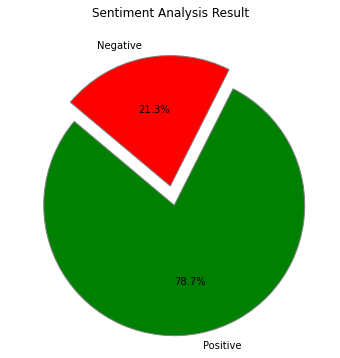

In [18]:
sentiment_counts = df['Sentiment'].value_counts()
print(sentiment_counts)


labels = sentiment_counts.index.map({0: 'Negative', 1: 'Positive'}).tolist()

sizes = sentiment_counts.values
colors = ['green', 'red']

# Explode the negative segment
explode = (0.15, 0)  # Explode the first segment (Negative)

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, wedgeprops={'edgecolor': 'grey'})
plt.title('Sentiment Analysis Result')
plt.show()

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ishan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ishan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ishan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    
    text = text.lower()
    
    # Remove punctuation marks and digits
    text = re.sub(r'[^\w\s]', '', text)  # Removes punctuation
    text = re.sub(r'\d+', '', text)      # Removes digits
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove short words, if necessary
    tokens = [word for word in tokens if len(word) > 2]
    
    # Remove stopwords and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [21]:
df['Processed_Review'] = df['Review'].apply(clean_text)

In [22]:
df.head()

,Review,Sentiment,Processed_Review
0,Conveniently located in the middle of the mall...,1,conveniently located middle mall road chineset...
1,Its difficult to find good restaurants in hill...,1,difficult find good restaurant hill station on...
2,We went there in The month of February . Yet i...,0,went month february yet crowded place got tabl...
3,I was there with my kids to enjoy dinner but w...,0,kid enjoy dinner ruined bad customer service w...
4,A very good place to get authentic Tibetan foo...,1,good place get authentic tibetan food though l...


In [23]:

positive_reviews = df[df['Sentiment'] == 1]['Processed_Review'].sum()
positive_word_freq = Counter(positive_reviews.split())


top_positive_words = positive_word_freq.most_common(10)



In [24]:
def plot_top_words(word_freq, title, color):
    words, counts = zip(*word_freq)
    plt.figure(figsize=(8, 6))
    plt.bar(words, counts, color=color)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

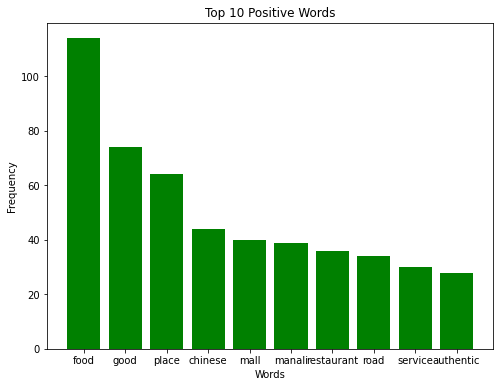

In [25]:
plot_top_words(top_positive_words, 'Top 10 Positive Words', 'green')

In [26]:
import random
import requests
from bs4 import BeautifulSoup
import re
import time
import pandas as pd
from transformers import BartTokenizer, BartForConditionalGeneration
import nltk
import os

In [27]:
import pandas as pd
from transformers import BartTokenizer, TFBartForConditionalGeneration

# Function to extract the first 2 lines from each review
def extract_first_two_lines(review):
    lines = review.split("\n")
    return " ".join(lines[:2])

def summarize_reviews(reviews):
    # Load BART tokenizer and model
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = TFBartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

    # Apply extract_first_two_lines to each review
    processed_reviews = [extract_first_two_lines(review) for review in reviews]
    combined_reviews = " ".join(processed_reviews)

    # Tokenize the combined reviews
    inputs = tokenizer(
        combined_reviews,
        return_tensors='tf',
        max_length=1024,
        truncation=True,
    )

    # Generate summary with a minimum length of 500
    summary_ids = model.generate(
        inputs['input_ids'],
        min_length=500,
        max_length=1024,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )

    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    return summary

# Read the CSV file into a DataFrame

# Extract the 'Reviews' column into a list
reviews_list = df['Review'].tolist()

# Work on only the first 10 reviews
first_10_reviews = reviews_list[:10]

# Summarize the reviews
summary = summarize_reviews(first_10_reviews)

# Print or use the summary as needed
print("Summary of Reviews:")
print(summary)


All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


Summary of Reviews:
Located in the middle of the mall road, this Chinese/Tibetan eatery is a must visit. They serve authentic, tasty and hygienic food with generous portions, the food seems slightly overpriced and the place is also a bit crammed. The only drawback is that its pricey but the potion they serve is good and the quality is good as well. The chicken in the chicken momos was hard as a rock. On complaining no reaction from the restaurant staff All good ordered was below average & is not worth the money. Do not visit this place we had the pleasure of eating at chopsticks in 2013 for the first time and we ended up at this Manali mall road restaurant again after 7 odd year and they did not disappoint on either occasion. a great place to dine, fantastic ambience, delicious food. Icing on the carke is their extremely courteous staff. you will definitely have a good experience. Located extremely good location just on Manali Mall road, a bit different than any other restaurants nearb

In [28]:
summary

"Located in the middle of the mall road, this Chinese/Tibetan eatery is a must visit. They serve authentic, tasty and hygienic food with generous portions, the food seems slightly overpriced and the place is also a bit crammed. The only drawback is that its pricey but the potion they serve is good and the quality is good as well. The chicken in the chicken momos was hard as a rock. On complaining no reaction from the restaurant staff All good ordered was below average & is not worth the money. Do not visit this place we had the pleasure of eating at chopsticks in 2013 for the first time and we ended up at this Manali mall road restaurant again after 7 odd year and they did not disappoint on either occasion. a great place to dine, fantastic ambience, delicious food. Icing on the carke is their extremely courteous staff. you will definitely have a good experience. Located extremely good location just on Manali Mall road, a bit different than any other restaurants nearby. You can reach he

In [31]:
len(summary)

2336